### Importing Libraries

In [3]:
pip install cassandra-driver

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade astrapy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from cassandra.cluster import Cluster
# from cassandra.auth import PlainTextAuthProvider

# # Credentials (replace with your actual values)
# ASTRA_DB_ID = '95513177-34f9-4add-b243-488b3b1b7a61'
# ASTRA_DB_REGION = 'ap-south-1' 
# ASTRA_DB_KEYSPACE = 'cust_seg_spc'
# ASTRA_DB_APPLICATION_TOKEN = 'AstraCS:QqQJcyRigeOkitFAIOMGtyub:08ff3dc0858aa88e385306c980d705cfb2632550ea9c88ad560c3318e6c4556f'

# # Path to your secure connect bundle (replace with the actual path)
# SECURE_CONNECT_BUNDLE_PATH = '/path/to/your/secure-connect-bundle.zip'

# # Create an auth provider using your credentials
# auth_provider = PlainTextAuthProvider(username=ASTRA_DB_ID + '-' + ASTRA_DB_REGION, password=ASTRA_DB_APPLICATION_TOKEN)

# # Create a cluster instance, providing the auth provider and the secure connect bundle path
# cluster = Cluster(cloud={'secure_connect_bundle': SECURE_CONNECT_BUNDLE_PATH}, auth_provider=auth_provider)

# # Connect to a session
# session = cluster.connect(ASTRA_DB_KEYSPACE)  

# # Execute a query (replace with your desired query)
# rows = session.execute('SELECT * FROM your_table_name')
# for row in rows:
#     print(row) 

# # Close the session and cluster
# #session.shutdown()
# #cluster.shutdown()

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [8]:
#pip install xgboost
#!pip install scikit-optimize

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pprint
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import statistics
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,make_scorer
from xgboost import XGBRegressor, DMatrix
# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from functools import partial
from sklearn.model_selection import StratifiedKFold
from time import time
import pandas as pd
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [4]:
from astrapy import DataAPIClient

# Initialize the client
client = DataAPIClient("AstraCS:eZCQtGSxUtYhjAOceJoObFDf:f2d49fb8cfb7484799a291f930e31fb26051c56fe8946bee3d3bb5a456d70251") #token from secure bundle
db = client.get_database_by_api_endpoint(
  "https://95513177-34f9-4add-b243-488b3b1b7a61-ap-south-1.apps.astra.datastax.com",
    namespace="cust_seg_spc",
)
      
print(f"Connected to Astra DB: {db.list_collection_names()}")

Connected to Astra DB: ['just_seg_m']


In [6]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

In [8]:
cloud_config = {
    'secure_connect_bundle': '/Users/goutamsarkar/Downloads/secure-connect-cust-segment.zip'
}
auth_provider = PlainTextAuthProvider(
   'eZCQtGSxUtYhjAOceJoObFDf', 
   'In9Qi.Nd0IXHC8CjTlKqxCDxbSfbbr_ZOg+IOZaimzGuvn1lK+-LfRyjPSAJ_2KiE06sFcshQy6fsehLYpp47T-l0DtdDjiPsBhgg2RePNg7yQk8KwCKxNIKgqT8qOZ_'
)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

In [ ]:
# import json
# # 1. Execute CQL Query
# query = "SELECT * FROM cust_seg_spc.just_seg_m LIMIT 5"  # Replace with your keyspace and table names
# rows = session.execute(query)

# # 2. Convert Results to List of Dictionaries
# data = []
# for row in rows:
#     data.append(dict(row._asdict()))

# # 3. Create Pandas DataFrame
# df = pd.DataFrame(data)

# # Now you have a DataFrame!
# print(df.head())  # Display the first few rows

In [26]:
import json
import pandas as pd

# 1. Execute CQL Query
query = "SELECT * FROM cust_seg_spc.just_seg_m LIMIT 5"
rows = session.execute(query)

# 2. Process and Transform Data
data = []
all_headers = set()

for row in rows:
    row_dict = row._asdict()

    # Parse JSON string:
    doc_json_dict = json.loads(row_dict['doc_json'])

    # Extract keys from doc_json and array_contains
    all_headers.update(doc_json_dict.keys())
    if row_dict['array_contains']:
        all_headers.add('Segment')
        all_headers.add('SRP')

    # Extract data based on all headers, preserving types:
    flattened_data = {}
    for header in all_headers:
        if header == 'Segment':
            flattened_data[header] = (
                row_dict['array_contains'][0].split()[0]
                if row_dict['array_contains']  # Handle empty array_contains
                else None
            )
        elif header == 'SRP':
            srp_value = row_dict['array_contains'][0].split()[1] if row_dict['array_contains'] else None
            # Try to convert to float, keep as string if it fails
            try:
                flattened_data[header] = float(srp_value)
            except (ValueError, TypeError):
                flattened_data[header] = srp_value
        else:
            value = doc_json_dict.get(header, None)
            # Determine and preserve type
            if isinstance(value, (int, float)):
                flattened_data[header] = value
            elif value is not None:  # Convert non-null values to strings
                flattened_data[header] = str(value)
            else:
                flattened_data[header] = None

    data.append(flattened_data)

# 3. Create DataFrame with all extracted headers
df = pd.DataFrame(data, columns=list(all_headers))

print(df)
print(df.dtypes)  # Print column data types for verification


  marital_status          store_type  brand_name units_per_case store_sqft  \
0              M  Deluxe Supermarket  Portsmouth             28      30797   
1              M  Deluxe Supermarket     Gorilla             21      33858   
2              M         Supermarket   Nationeel             16      21215   
3              S  Deluxe Supermarket    BBB Best             10      27694   
4              M  Deluxe Supermarket    Hermanos             33      27694   

     cost    SRP meat_sqft grocery_sqft                                   _id  \
0   76.88   S1.7      4262        20141  aae9e29e-7d4d-40ae-a9e2-9e7d4d00ae63   
1  136.74  S1.57      4694        22123  9120fcd6-309b-43f6-a0fc-d6309be3f66c   
2   69.63  S1.31      3164        13305  ed13f9d1-c209-45a3-93f9-d1c20905a307   
3   69.47  S1.97      3610        18670  8e9618a2-1ca1-4bf3-9618-a21ca1dbf39c   
4   95.78  S3.36      3610        18670  ca183422-5b83-46e0-9834-225b83a6e052   

   ... net_weight total_children      occupa

In [28]:
import pandas as pd

# Assuming you already have the DataFrame `df` from your previous operations

# Columns to be converted to float
float_columns = ['store_sales(in millions)', 'store_cost(in millions)', 'gross_weight', 'net_weight', 'cost']

# Columns to be converted to double (equivalent to float64 in Pandas)
double_columns = ['meat_sqft', 'store_sqft', 'grocery_sqft', 'units_per_case', 
                  'avg_cars_at_home(approx)', 'num_children_at_home', 'total_children', 
                  'unit_sales(in_millions)', 'units_per_case']  

# Convert columns to float64 (double)
for col in double_columns:
    if col in df.columns:  # Check if column exists
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert columns to float32
for col in float_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce', downcast='float')

print(df)
print(df.dtypes)  # Print column data types to verify the changes


  marital_status          store_type  brand_name  units_per_case  store_sqft  \
0              M  Deluxe Supermarket  Portsmouth              28       30797   
1              M  Deluxe Supermarket     Gorilla              21       33858   
2              M         Supermarket   Nationeel              16       21215   
3              S  Deluxe Supermarket    BBB Best              10       27694   
4              M  Deluxe Supermarket    Hermanos              33       27694   

         cost    SRP  meat_sqft  grocery_sqft  \
0   76.879997   S1.7       4262         20141   
1  136.740005  S1.57       4694         22123   
2   69.629997  S1.31       3164         13305   
3   69.470001  S1.97       3610         18670   
4   95.779999  S3.36       3610         18670   

                                    _id  ... net_weight total_children  \
0  aae9e29e-7d4d-40ae-a9e2-9e7d4d00ae63  ...       9.19              4   
1  9120fcd6-309b-43f6-a0fc-d6309be3f66c  ...       6.78              1   
2 

In [30]:
# exploring shape and size
df.shape,df.size

((5, 35), 175)

#### Data preprocessing and Exploratory Data Analysis  

In [32]:
# checking missing values
missing_values = df.isnull().sum()/len(df)*100
print(missing_values)

marital_status          0.0
store_type              0.0
brand_name              0.0
units_per_case          0.0
store_sqft              0.0
cost                    0.0
SRP                     0.0
meat_sqft               0.0
grocery_sqft            0.0
_id                     0.0
store_city              0.0
low_fat                 0.0
salad_bar               0.0
coffee_bar              0.0
num_children_at_home    0.0
prepared_food           0.0
promotion_name          0.0
houseowner              0.0
florist                 0.0
sales_country           0.0
food_department         0.0
member_card             0.0
education               0.0
recyclable_package      0.0
media_type              0.0
net_weight              0.0
total_children          0.0
occupation              0.0
food_family             0.0
Segment                 0.0
store_state             0.0
gender                  0.0
gross_weight            0.0
frozen_sqft             0.0
video_store             0.0
dtype: float64


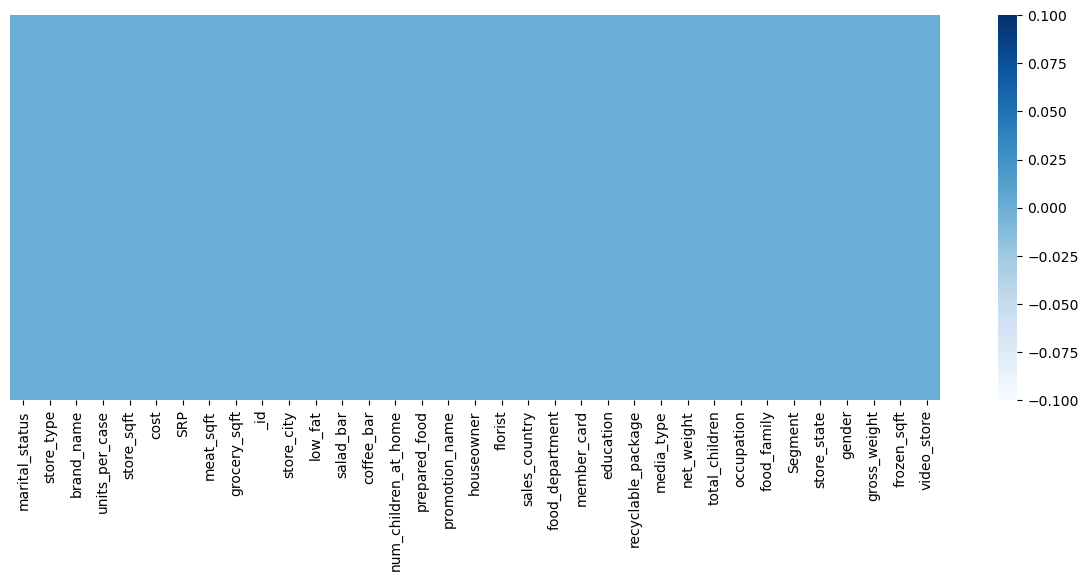

In [34]:
# heatmap to check the null values
dim=(15,5)
fig, ax = plt.subplots(figsize=dim)
sns.heatmap(df.isnull(), yticklabels=False, cmap='Blues', ax=ax);

In [36]:
# Checking presence of duplicate dataset
percentage = df.duplicated(keep=False).value_counts(normalize=True) * 100
print (percentage)

False    100.0
Name: proportion, dtype: float64


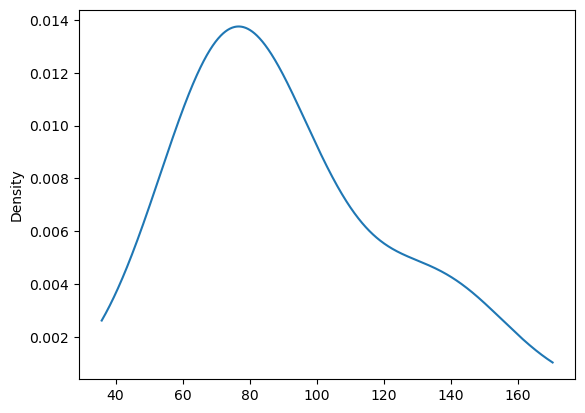

In [38]:
# target class distribution
df['cost'].plot.density();

In [ ]:
# # plot showing the frequency of each unique data in 'food_category'
# dim=(5,10)
# fig, ax = plt.subplots(figsize=dim)
# sns.countplot(y=df['food_category'],ax=ax);

<Axes: xlabel='count', ylabel='promotion_name'>

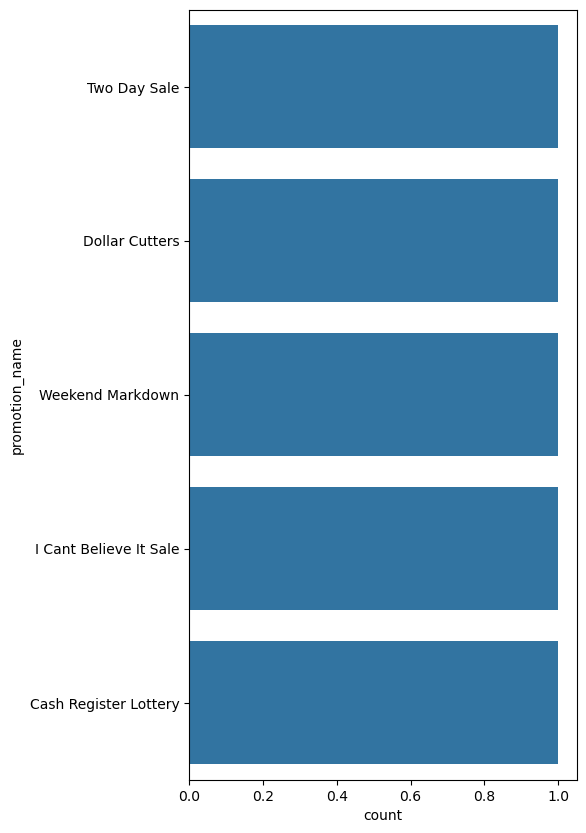

In [40]:
# plot showing the frequency of each unique data in 'promotion_name'
dim=(5,10)
fig, ax = plt.subplots(figsize=dim)
sns.countplot(y=df['promotion_name'],ax=ax)

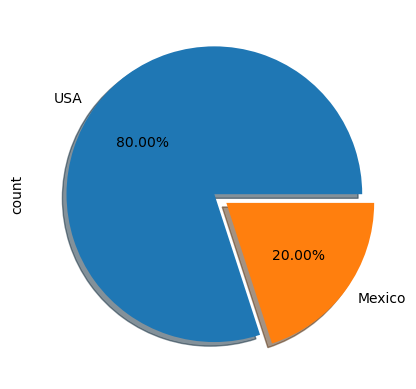

In [42]:
explode = [0.1 if i == 1 else 0 for i in range(df['sales_country'].nunique())]  # Explode the second slice (index 1)
df['sales_country'].value_counts().plot(kind='pie', autopct='%1.2f%%', explode=explode, shadow=True);

In [ ]:
# # plot showing the relation between store sales and cost
# df.plot.scatter(y='store_cost(in millions)',x='store_sales(in millions)')

In [ ]:
# # store cost frequency distribution
# df['store_cost(in millions)'].plot.hist()

<Axes: ylabel='Frequency'>

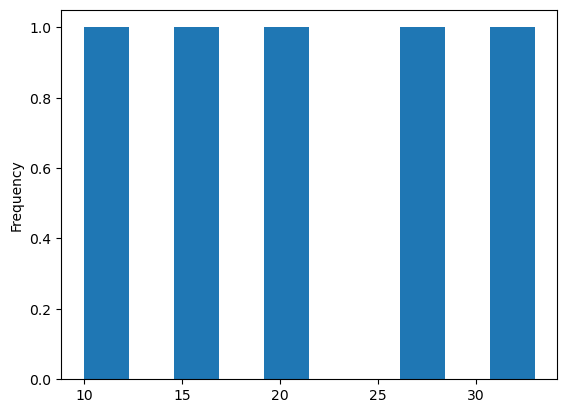

In [44]:
# units per case frequency distribution
df['units_per_case'].plot.hist()

<Axes: ylabel='count'>

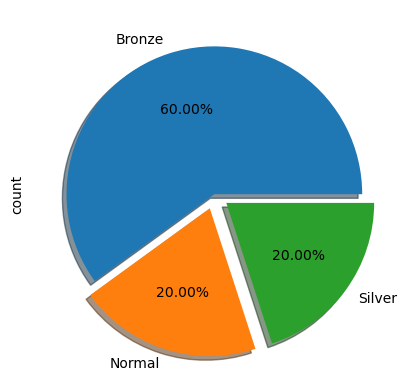

In [46]:
# distribution of member_card
explode = [0.1 if i > 0 else 0 for i in range(df['member_card'].nunique())]
df['member_card'].value_counts().plot(kind='pie', autopct='%1.2f%%', explode=explode, shadow=True)

<Axes: xlabel='count', ylabel='gender'>

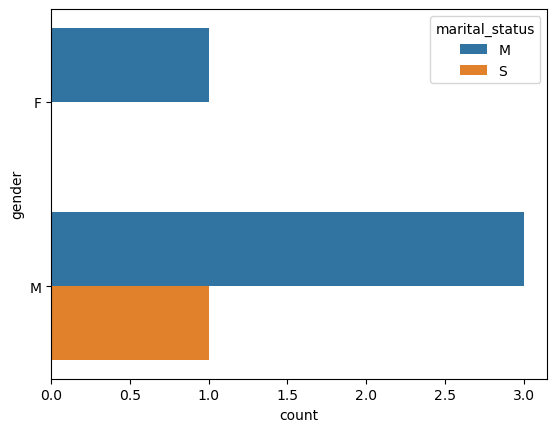

In [48]:
# relational distribution of marital status and gender
sns.countplot(y=df['gender'],hue=df['marital_status'])

<Axes: xlabel='houseowner', ylabel='count'>

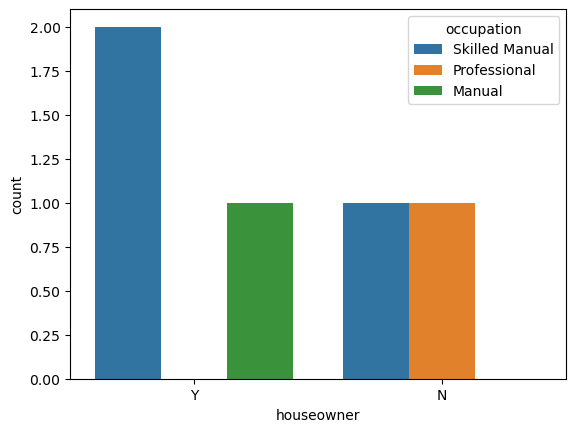

In [50]:
# plot showing the frequency distribution of houseowner and their respective occupations
sns.countplot(x=df['houseowner'],hue=df['occupation'])

<Axes: xlabel='count', ylabel='education'>

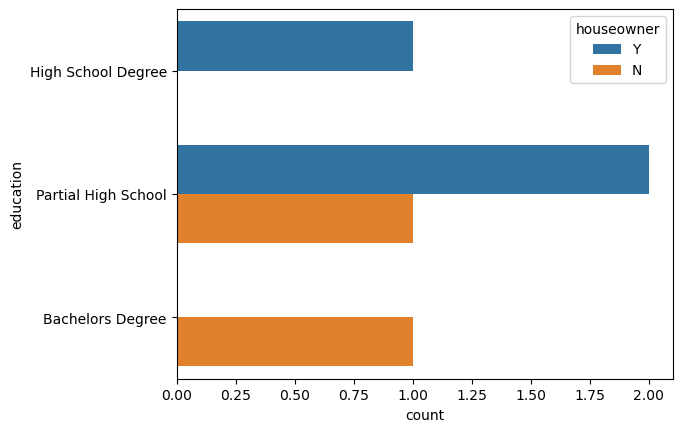

In [52]:
# relation distribution of education and owning a house
sns.countplot(y=df['education'],hue=df['houseowner'])

<Axes: ylabel='count'>

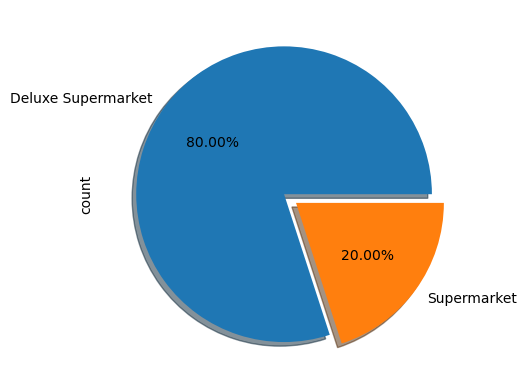

In [54]:
# distribution of store_type
explode = [0.1 if i > 0 else 0 for i in range(df['store_type'].nunique())]  # Dynamic explode
df['store_type'].value_counts().plot(kind='pie', autopct='%1.2f%%', explode=explode, shadow=True)

In [153]:
# d={'$10K - $30K':20000,'$50K - $70K':60000, '$30K - $50K':40000, '$70K - $90K':80000,
#        '$110K - $130K':120000, '$130K - $150K':140000, '$150K +':150000, '$90K - $110K':100000}

In [ ]:
# df['avg. yearly_income'] = df['avg. yearly_income'].apply(lambda x: d.get(x))


In [247]:
# pipeline_df=df.copy()

In [68]:
df_x = df[['sales_country', 'total_children', 'education',
       'member_card', 'occupation', 'houseowner', 'num_children_at_home','brand_name', 'gross_weight',
       'net_weight', 'recyclable_package', 'low_fat', 'units_per_case',
       'store_type', 'store_city', 'store_state', 'store_sqft', 'grocery_sqft',
       'frozen_sqft', 'meat_sqft', 'coffee_bar', 'video_store', 'salad_bar',
       'prepared_food', 'florist', 'media_type']]

In [70]:
y = df[['cost']]

#### Feature Encoding 

In [72]:
### Features Encoding 
def encode(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]],drop_first =True)
    X = pd.concat([original_dataframe,dummies],axis = 1)
    X = X.drop([feature_to_encode],axis = 1)
    return X

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df_x, y, test_size=0.20, random_state=42)

**Base Model: Linear Regression**

In [112]:
def linear_model(X,y):
    parameters = {'fit_intercept':[True,False]}
    # parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
    linear = LinearRegression()
    linear_search = RandomizedSearchCV(linear,parameters,cv=3)
    linear_search.fit(X.values,y.values)
    linear_confirmed = linear_search.best_estimator_
    y_pred = linear_confirmed.predict(X_test)
    
    print("R^2 Linear: ", r2_score(y_test, y_pred))
    print("MAE Linear:", mean_absolute_error(y_test,y_pred))
    print("RMSE Linear:",np.sqrt(mean_squared_error(y_test, y_pred)))
    return(y_pred)

In [108]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import RandomizedSearchCV, train_test_split

# # 1. Identify Categorical Features
# categorical_features = X_train.select_dtypes(include=['object']).columns

# # 2. Create a ColumnTransformer for Preprocessing
# preprocessor = ColumnTransformer(
#     transformers=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)],
#     remainder='passthrough'
# )

# # 3. Create a Pipeline for Model and Preprocessing
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('linear', LinearRegression())
# ])

# # 4. Hyperparameter Tuning (Optional)
# parameters = {
#     'linear__fit_intercept': [True, False]
# }
# linear_search = RandomizedSearchCV(pipeline, parameters, cv=3)

# # 5. Fit and Evaluate Model
# linear_search.fit(X_train, y_train)
# y_pred = linear_search.predict(X_test)


# # Extract coefficients and intercept
# onehot_encoder = best_linear_model.named_steps['preprocessor'].transformers_[0][1] 
# feature_names = onehot_encoder.get_feature_names_out(input_features=categorical_features)

# # Convert feature names to a list to ensure compatibility
# feature_names = list(feature_names) + list(X_train.select_dtypes(include=['number']).columns)

# coef = best_linear_model.named_steps['linear'].coef_
# intercept = best_linear_model.named_steps['linear'].intercept_

# # Print the results in a readable format
# print("Linear Regression Results:")
# print("-------------------------")
# print("Intercept:", intercept)


Linear Regression Results:
-------------------------
Intercept: [67.40625999]


In [118]:
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# 1. Identify Categorical Features
categorical_features = X_train.select_dtypes(include=['object']).columns

# 2. Create a ColumnTransformer for Preprocessing
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

# 3. Create a Pipeline for Model and Preprocessing
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('linear', LinearRegression())
])

# 4. Hyperparameter Tuning (Optional)
parameters = {
    'linear__fit_intercept': [True, False]
}
linear_search = RandomizedSearchCV(pipeline, parameters, cv=3)

# 5. Fit and Evaluate Model
linear_search.fit(X_train, y_train)
y_pred = linear_search.predict(X_test)

# Get the best model from RandomizedSearchCV
best_linear_model = linear_search.best_estimator_

# Pickle the best model (Save)
with open('linear_model.pkl', 'wb') as file:
    pickle.dump(best_linear_model, file)

# --- Later, you can load the model ---
# with open('linear_model.pkl', 'rb') as file:
#    loaded_model = pickle.load(file)
# y_pred_loaded = loaded_model.predict(X_test) # Use the loaded model to make predictions


# Extract coefficients and intercept (Use the original fitted model for this)
onehot_encoder = best_linear_model.named_steps['preprocessor'].transformers_[0][1] 
feature_names = onehot_encoder.get_feature_names_out(input_features=categorical_features)

# Convert feature names to a list to ensure compatibility
feature_names = list(feature_names) + list(X_train.select_dtypes(include=['number']).columns)

coef = best_linear_model.named_steps['linear'].coef_
intercept = best_linear_model.named_steps['linear'].intercept_

# Print the results in a readable format
print("Linear Regression Results:")
print("-------------------------")
print("Intercept:", intercept)


Linear Regression Results:
-------------------------
Intercept: [67.40625999]


In [120]:
#--- load the pickel model ---
with open('linear_model.pkl', 'rb') as file:
   loaded_model = pickle.load(file)
y_pred_loaded = loaded_model.predict(X_test) # Use the loaded model to make predictions